# Project specification


## 1) Calibration (camera matrix, distortion coefficients)

## Pipeline
* 2) Color transform, Gradients -> thresholded binary image
* 3) Perspective transform
* 4) Identification of lane line pixels
* 5) Radius of curvature calculation
* 6) Lane area plotted back down onto the road

* (7) Lane history + smoothing)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from help_func import draw_lines_from_points, show_img, show_imgs
import pickle
from collections import deque
# for interactive plots
# %matplotlib notebook
# %matplotlib inline

# Camera calibration

Criteria:  
Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

Camera calibration requires both object points (x,y,z) and image points (x,y) of the calibration patterns.  
Since the chessboard pattern is assumed to be fixed at the (x,y) plane at z=0, the object points for all 9x6 calibration images are (0,0,0), (1,0,0), ... (8,5,0).  
The image points are determinded by the cv2.findChessboardCorners(), which outputs the 2D-coordinates of all chessboard corners from the input image.  

The function cv2.calibrateCamera() computes the camera matrix and distortion coefficients by using object and image points. Since the use of more than 10 calibration images is recommended ([openCV documentation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html)), all of the provided 20 images are used. The respective object and image points of the images are simply appended and then passed to the calibration function. 

Distorted images can now be corrected by using the cv2.undistort() function, which takes the calibration matrix and distortion coefficients as input arguments. An example of an undistorted calibration image is provided below.

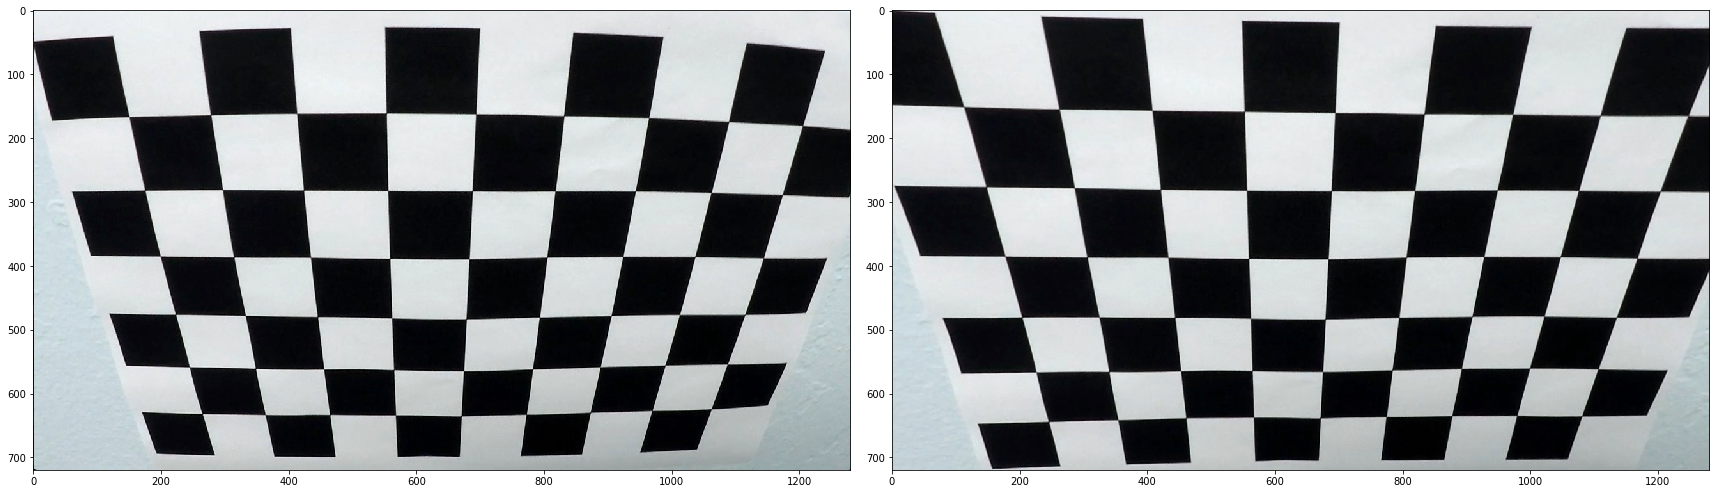

In [2]:
# initialize array for object points with dimensions (6*9, 3)
objp = np.zeros((6*9,3), np.float32)
# create mesh grid, transpose and reshape to get an (6*9, 2) array 
# for all object points (z component is assumed to be 0)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# initialize arrays for object- and image points from all calibration images
objpts = [] # 3D points in real world space
imgpts = [] # 2D points in image plane

# get list of all available calibration images
cal_images = glob.glob('camera_cal/calibration*.jpg')

# find chessboard corners in all images
for idx, img_name in enumerate(cal_images):
    img = cv2.imread(img_name) # read image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    
    # find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    # if corners were found, object- and image points are added
    if ret == True:
        objpts.append(objp)
        imgpts.append(corners)

        # draw and display/save corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)        
        # folder_name = 'output_images/'
       # file_name = 'chessboard_corners_'+img_name[11:]
       # cv2.imwrite(folder_name+file_name, img)
#         plt.figure()
#         plt.imshow(img)
#         cv2.waitKey(500)

dist_img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img_size, None ,None)

undist_img = cv2.undistort(dist_img, mtx, dist_coeff, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(dist_img)
ax2.imshow(undist_img)

# plt.imshow(undist_img)
# cv2.imwrite('output_images/calibration2_undistorted.jpg', undist)

# Pipeline (test images)

#### Criteria: Provide an example of a distortion-corrected image.

Now that the calibration matrix and distortion coefficients are available after the use of cv2.calibrateCamera(), every image taken with the same camera can be undistorted. The function cv2.undistort() is used for this task again. The results are shown below.

In [3]:
def undistort(dist_img):
    undist_img = cv2.undistort(dist_img, mtx, dist_coeff, None, mtx)
    return undist_img

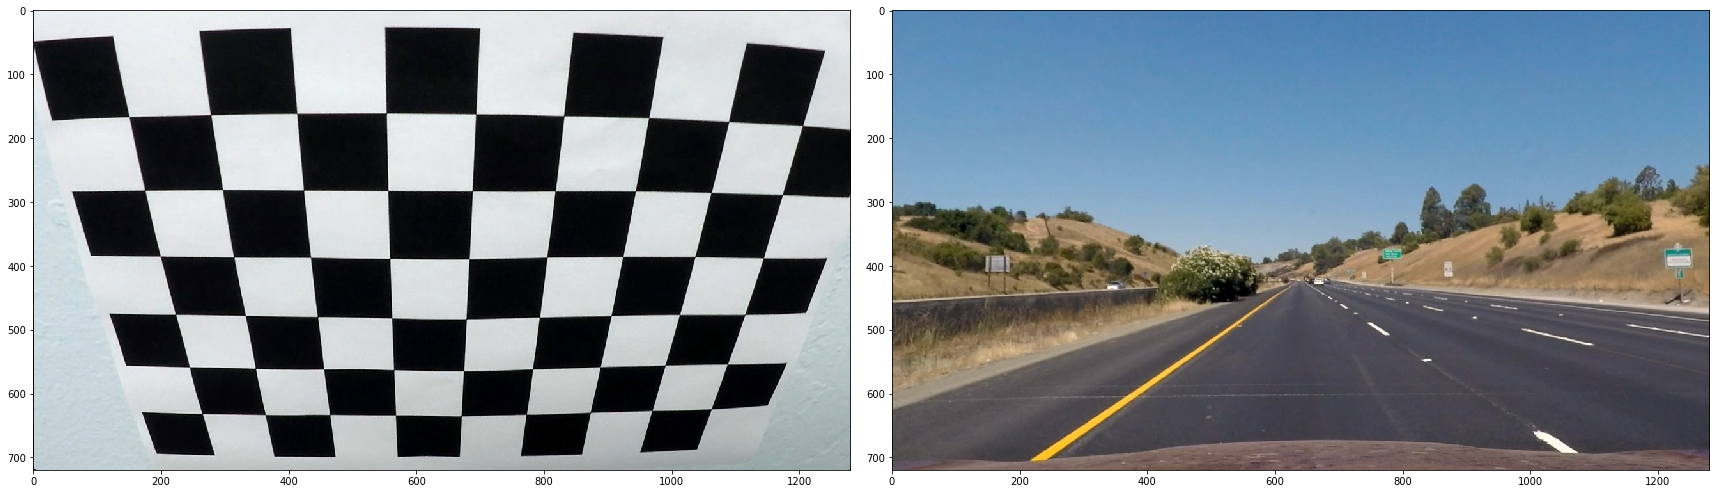

In [4]:
src_img = mpimg.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])

undist_img = undistort(src_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(dist_img)
ax2.imshow(undist_img)

#### Criteria: Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

A perspective transform requires a transformation matrix which can be computed by using the cv2.getPerspectiveTransform() function. This function takes 4 source points and 4 destination points as an input and outputs the transformation matrix. The choice of points is shown in the image below.
Since the lane lines on the road inside the region of interest represent a rectangle, the destination points are chosen to build a rectange as well. This choice leads to a bird's eye view after the perspective transform. 
In case of swapping source and image points before passing them to the cv2.getPerspectiveTransform() function, the output is a matrix for transforming from bird's eye view back to the original perspective.

The transform is performed with the cv2.warpPerspective() function, which takes the image and the transformation matrix as input and outputs the transformed ("warped") image.  
An example of a transformed image is shown below.

In [5]:
# define function for perspective transform matrix and inverse matrix
def get_warp_mat(src_pts, dst_pts):
    warp_mtx = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warp_inv_mtx = cv2.getPerspectiveTransform(dst_pts, src_pts)
    return (warp_mtx, warp_inv_mtx)

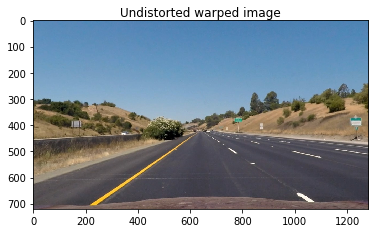

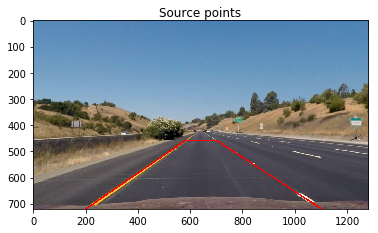

In [6]:
# define source and destination points for perspective transform

# read and undistort image
wrp_src_img = mpimg.imread('test_images/straight_lines1.jpg')
wrp_img_size = (wrp_src_img.shape[1], wrp_src_img.shape[0])
undist_wrp_img = cv2.undistort(wrp_src_img, mtx, dist_coeff)

# show undistorted image to determine source points
# %matplotlib notebook # enables zoom and mouse coordinates

show_img(undist_wrp_img, None, 'Undistorted warped image')
# plt.figure()
# plt.imshow(undist_wrp_img)
# plt.title('Undistorted image')

# source points manually determined from test image "straight_lines1.jpg"
src_pts = np.array([[580, 460], [700, 460], [1100, wrp_img_size[1]], [200, wrp_img_size[1]]], 
                   np.float32).reshape((4, 1, 2))
# src_pts = np.array([[560, 475], [725, 475], [1100, img_size[1]], [200, img_size[1]]], 
#                    np.float32).reshape((4, 1, 2))
# src_pts = np.array([[595, 450], [685, 450], [1100, img_size[1]], [200, img_size[1]]], 
#                    np.float32).reshape((4, 1, 2))

# destination points for perspective transformation
lane_dist = 700 # in pixels
mid_pnt = wrp_img_size[0]//2
dst_pts = np.array([[mid_pnt - lane_dist/2, 0], [mid_pnt + lane_dist/2, 0], 
                    [mid_pnt + lane_dist/2, wrp_img_size[1]], [mid_pnt - lane_dist/2, wrp_img_size[1]]], 
                   np.float32).reshape((4, 1, 2))

# show undistorted image with source area
undist_wrp_img_src = np.copy(undist_wrp_img)
draw_lines_from_points(undist_wrp_img_src, src_pts)
show_img(undist_wrp_img_src, None, 'Source points')

In [7]:
# compute perspective transform matrix and inverse matrix
warp_mtx, warp_inv_mtx = get_warp_mat(src_pts, dst_pts)
print('transformation matrix:\n', warp_mtx)
print('inverse transformation matrix:\n', warp_inv_mtx)

transformation matrix:
 [[ -5.55555556e-01  -1.50244200e+00   9.85726496e+02]
 [  0.00000000e+00  -1.97802198e+00   9.09890110e+02]
 [  2.93511629e-19  -2.38095238e-03   1.00000000e+00]]
inverse transformation matrix:
 [[  1.71428571e-01  -7.68518519e-01   5.30285714e+02]
 [  4.58932415e-17  -5.05555556e-01   4.60000000e+02]
 [  2.24588775e-19  -1.20370370e-03   1.00000000e+00]]


In [8]:
# define perspective transform function
def warp(img):
    warped_img = cv2.warpPerspective(img, warp_mtx, wrp_img_size, flags=cv2.INTER_LINEAR)
    return warped_img

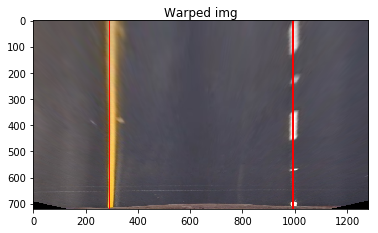

In [9]:
# perform perspective transformation
warped_img = cv2.warpPerspective(undist_wrp_img, warp_mtx, wrp_img_size, flags=cv2.INTER_LINEAR)

# draw lines on warped image and plot
warped_img_roi = np.copy(warped_img)
draw_lines_from_points(warped_img_roi, dst_pts)
show_img(warped_img_roi, None, 'Warped img')

#### Criteria: Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

##### gradient (function sobel_thresh)

>"In our last example, output datatype is cv2.CV_8U or np.uint8. But there is a slight problem with that. Black-to-White transition is taken as Positive slope (it has a positive value) while White-to-Black transition is taken as a Negative slope (It has negative value). So when you convert data to np.uint8, all negative slopes are made zero. In simple words, you miss that edge.

>If you want to detect both edges, better option is to keep the output datatype to some higher forms, like cv2.CV_16S, cv2.CV_64F etc, take its absolute value and then convert back to cv2.CV_8U. Below code demonstrates this procedure for a horizontal Sobel filter and difference in results."

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_gradients/py_gradients.html

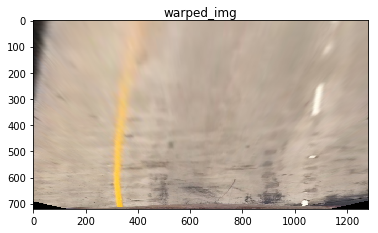

In [10]:
# read image and get size
# src_img = mpimg.imread('test_images/straight_lines1.jpg')
src_img = mpimg.imread('test_images/test1.jpg')
img_size = (src_img.shape[1], src_img.shape[0])

# undistort and warp
undist_img = undistort(src_img)
warped_img = warp(undist_img)

plt.imshow(warped_img)
plt.title('warped_img')

Grdient thresholds

In [11]:
# gradient thresholds

# define gradient threshold function
def grad_thresh(img, orient='x', 
                kernel = 3, thresh=(0, 255)):
    """Creates thresholded binary image based on directional 
    gradient"""
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # take derivative in 'orient' direction
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    else:
        print('only x and y are accepted as 2nd argument')
        return None
    # calculate absolute value and scale to 8-bit
    abs_sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))
    # create binary image
    grad_bin = np.zeros_like(scaled_sobel)
    grad_bin[(scaled_sobel >= thresh[0]) & 
                (scaled_sobel <= thresh[1])] = 1
    # return binary image
    return grad_bin

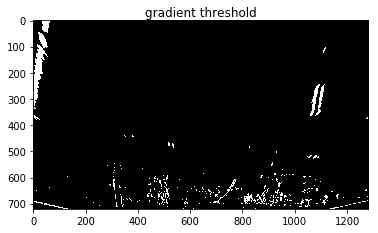

In [12]:
# create and plot gradient threshold image
bin_grad_img = grad_thresh(warped_img, 'x', 
                          kernel = 9, thresh = (20, 100))
plt.imshow(bin_grad_img, cmap = 'gray')
plt.title('gradient threshold')

In [13]:
# define gradient magnitude function
def grad_mag_thresh(img, kernel = 3, thresh = (0, 255)):
    # convert to grayscale    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # apply sobel in both x and y direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # calculate magnitude
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # scale to 8-bit and convert to type uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # create binary magnitude image
    grad_mag_bin = np.zeros_like(scaled_sobel)
    grad_mag_bin[(scaled_sobel >= thresh[0]) & 
            (scaled_sobel <= thresh[1])] = 1
    # return binary image
    return grad_mag_bin

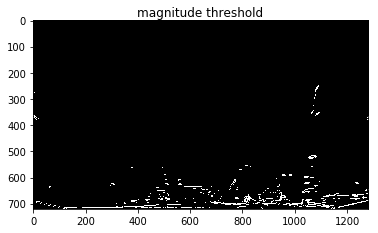

In [14]:
# create and plot gradient magnitude threshold image
bin_grad_mag_img = grad_mag_thresh(warped_img, kernel = 9, thresh = (30, 100))
plt.imshow(bin_grad_mag_img, cmap = 'gray')
plt.title('magnitude threshold')

In [15]:
# define gradient direction threshold function
def grad_dir_thresh(image, kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # apply sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # calculate absolute values of sobelx and sobely
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    # calculate gradient direction
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # apply threshold
    grad_dir_bin = np.zeros_like(gray)
    grad_dir_bin[(grad_dir >= thresh[0]) & 
            (grad_dir <= thresh[1])] = 1
    
    return grad_dir_bin

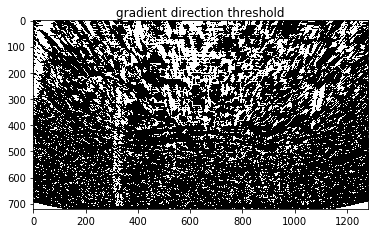

In [16]:
# create and plot gradient direction threshold image
grad_dir_bin_img = grad_dir_thresh(warped_img, 
                         kernel = 7, thresh = (0, 0.4))
plt.imshow(grad_dir_bin_img, cmap = 'gray')
plt.title('gradient direction threshold')

Color thresholds

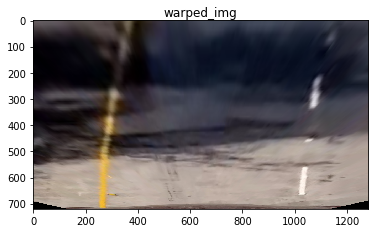

In [17]:
src_img = mpimg.imread('test_images/test5.jpg')
img_size = (src_img.shape[1], src_img.shape[0])

# undistort and warp
undist_img = undistort(src_img)
warped_img = warp(undist_img)

plt.imshow(warped_img)
plt.title('warped_img')

In [18]:
# color thresholds

def rgb_color_thresh(img, ch, thresh=(0, 255), show=False):
    if ch=='r':
        out = img[:,:,0] # r channel
    if ch=='g':
        out = img[:,:,1] # g channel
    if ch=='b':
        out = img[:,:,2] # b channel
        
    if show==True:
        show_img(out, 'gray', ch)

    # apply threshold
    rgb_col_bin = np.zeros_like(img[:,:,2])
    rgb_col_bin[(out > thresh[0]) & (out <= thresh[1])] = 1
    
    return rgb_col_bin
    

# define color threshold function
def hls_color_thresh(img, ch, thresh=(0, 255), show=False):
    # convert image to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    if ch=='h':
        out = hls[:,:,0] # h channel
    if ch=='l':
        out = hls[:,:,1] # l channel
    if ch=='s':
        out = hls[:,:,2] # s channel
        
    if show==True:
        show_img(out, 'gray', ch)

    # apply threshold
    hls_col_bin = np.zeros_like(hls[:,:,2])
    hls_col_bin[(out > thresh[0]) & (out <= thresh[1])] = 1
    return hls_col_bin

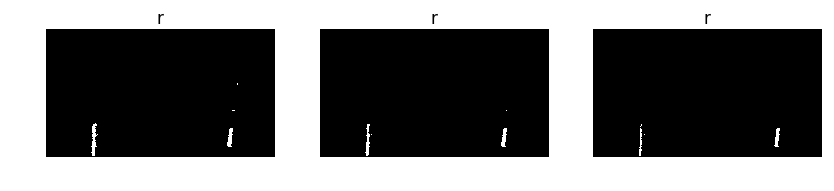

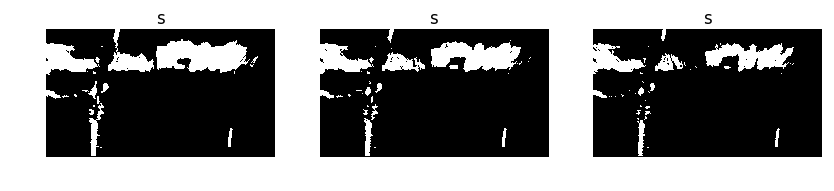

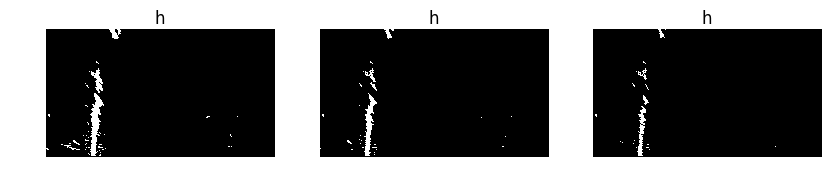

In [19]:
# create and plot color threshold image
r1 = rgb_color_thresh(warped_img, 'r', thresh = (220, 255), show=False)#1#2#3-4#5#6
r2 = rgb_color_thresh(warped_img, 'r', thresh = (225, 255), show=False)#1#2#3#4#6
r3 = rgb_color_thresh(warped_img, 'r', thresh = (230, 255), show=False)#1#2#3#4#6

r_imgs = (r1,r2,r3)
cmaps=('gray', 'gray', 'gray')
show_imgs(r_imgs, cmaps, (['r']*3), 1,3)



s1 = hls_color_thresh(warped_img, 's', thresh = (110, 255), show=False)#1#2#3(#4)#6
s2 = hls_color_thresh(warped_img, 's', thresh = (120, 255), show=False)#1#2#3(#4)#6
s3 = hls_color_thresh(warped_img, 's', thresh = (130, 255), show=False)#1#2#3(#4)(#5)#6

s_imgs = (s1,s2,s3)

show_imgs(s_imgs, cmaps, (['s']*3), 1,3)


h1 = hls_color_thresh(warped_img, 'h', thresh = (17, 30), show=False)#2#3#5#6
h2 = hls_color_thresh(warped_img, 'h', thresh = (18, 50), show=False)#2#3#4#5#6
h3 = hls_color_thresh(warped_img, 'h', thresh = (19, 50), show=False)#1#2#3#4#5#6

h_imgs = (h1,h2,h3)

show_imgs(h_imgs, cmaps, (['h']*3), 1,3)

In [20]:
def create_bin_img(warped_img):
    # h_col_bin = hls_color_thresh(warped_img, 'h', thresh = (15, 100), show=False)
    r_col_bin = rgb_color_thresh(warped_img, 'r', thresh = (220, 255), show=False)
    s_col_bin = hls_color_thresh(warped_img, 's', thresh = (130, 255), show=False)
    h_col_bin = hls_color_thresh(warped_img, 'h', thresh = (19, 50), show=False)
#     show_img(r_col_bin, 'gray', 'rgb r color channel')
#     show_img(s_col_bin, 'gray', 'hls s color channel')

    bin_img = np.zeros_like(s_col_bin)
    bin_img[(r_col_bin==1) | ( (s_col_bin==1) & (h_col_bin==1) )] = 1

#     show_img(bin_img, 'gray', 'combination')
    return bin_img

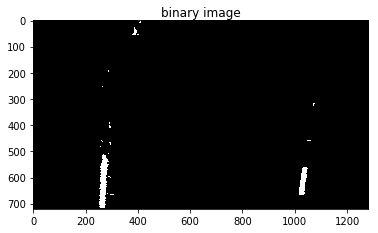

In [21]:
bin_img = create_bin_img(warped_img)
show_img(bin_img, 'gray', 'binary image')

#### Criteria: Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?



In [22]:
# functions called in find_lane_pixels() function

def create_blank_3ch_img():
    blank_img = np.zeros_like(src_img)
    return blank_img


# functions called inside for loop
    
def draw_win(img, win_x, win_y):
    # draw windows on image
    cv2.rectangle(img, (win_x[0], win_y[0]), (win_x[1], win_y[1]), (0, 255, 0), 2)
    return None

In [23]:
# number of sliding windows
n_win = 9
# windows width (+/-margin)
margin = 100
# min number of pixels to recenter window
min_pix = 50
# set window height
win_h = np.int(img.shape[0]//n_win)

In [24]:
test = create_blank_3ch_img()

In [25]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, hist_len):
        # number of recent lines to be stored
        self.n_prev_lanes = hist_len
        # boolean deque to indicate which of the last n frames were valid
        self.count_fails = 0
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen=self.n_prev_lanes) 
        #average x values of the fitted line over the last n iterations
        self.bestx = None    
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = deque(maxlen=self.n_prev_lanes)
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # curve radii of the last n fits
        self.recent_curverad = deque(maxlen=self.n_prev_lanes)
        # average of the last n radii
        self.best_rad = None
        #radius of curvature of the line in some units
        self.radius = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.reset()
    
    def reset(self):
        self.n_prev_lanes = hist_len
        self.count_fails = 0
        self.detected = False  
        self.recent_xfitted = deque(maxlen=self.n_prev_lanes) 
        self.bestx = None    
        self.best_fit = deque(maxlen=self.n_prev_lanes)
        self.current_fit = [np.array([False])]
        self.recent_curverad = deque(maxlen=self.n_prev_lanes)
        self.best_rad = None
        self.radius = None
        self.line_base_pos = None 
        self.diffs = np.array([0,0,0], dtype='float') 
        self.allx = None  
        self.ally = None

In [26]:
def sliding_window(img, side, show_win=False):
    print('sliding windows, ', side)
    # create 3 channel image
    out_img = np.dstack((img, img, img))*255
        
    # create histogramm from bottom half of the image
    hist = np.sum(img[img.shape[0]//2:, :], axis = 0)
    # find midpoint
    mid_pnt = np.int(hist.shape[0]//2)
    # find left and right windows start positions based on peaks in histogram
    if side=='left':
        x_start = np.argmax(hist[:mid_pnt])
    if side=='right':
        x_start = np.argmax(hist[mid_pnt:]) + mid_pnt
    # if no line is detected
    if (x_start==0 | x_start== mid_pnt):
        x_start = -1
    
    # find x and y positions of all nonzero pixels
    nonzero_y = np.array(img.nonzero()[0])
    nonzero_x = np.array(img.nonzero()[1])
    
    # initialize current window positions with start values from histogram
    x_current = x_start
    
    # initialization of empty lists for lane pixel indices
    lane_inds = []

    # loop through all windows
    for win in range(n_win):
        
        # determine window y boundaries
        win_y_low = img.shape[0] - (win + 1) * win_h
        win_y_high = img.shape[0] - win * win_h
        win_y = np.array([win_y_low, win_y_high])
        # determine window x boundaries
        win_x_low = x_current - margin
        win_x_high = x_current + margin
        win_x = np.array([win_x_low, win_x_high])
        
        # find nonzero pixels in x and y within current window
        good_inds = ((nonzero_y >= win_y[0]) & (nonzero_y < win_y[1]) & 
                                  (nonzero_x >= win_x[0]) & (nonzero_x < win_x[1])).nonzero()[0]

        # append the indices to the lists
        lane_inds.append(good_inds)
        
        # if pixels in window > minpix pixels, recenter next window on their mean position
        if np.count_nonzero(good_inds) > min_pix:
            x_current = np.uint16(np.mean(nonzero_x[good_inds]))
        
        if show_win==True:
            # draw current window
            draw_win(out_img, win_x, win_y)
        
    try:
        # create one array of indices out of the list of lists
        lane_inds = np.concatenate(lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
        
    # Extract left and right line pixel positions
    x = nonzero_x[lane_inds]
    y = nonzero_y[lane_inds] 
    
    ## Visualization ##
    # Colors in the left and right lane regions
    if side=='left':
        out_img[y, x] = [255, 0, 0]
    if side=='right':
        out_img[y, x] = [0, 0, 255]
    
    return (x, y, out_img)

sliding windows,  left


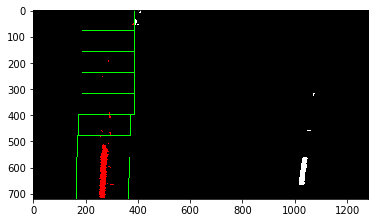

sliding windows,  right


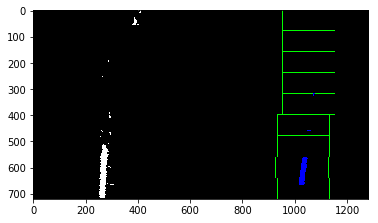

In [27]:
left_x, left_y, lane_pix_img = sliding_window(bin_img, 'left', True)
plt.imshow(lane_pix_img)
plt.show()

right_x, right_y, lane_pix_img = sliding_window(bin_img, 'right', True)
plt.imshow(lane_pix_img)
plt.show()



In [97]:
def fit_poly(img, side, show=False):
    print('fit poly, ', side)
    if side=='left':
        if left_line.detected == False:
            x, y, lane_pix_img = sliding_window(img, 'left', False)
        if left_line.detected == True:
            x, y, lane_pix_img = proximity_search(img, 'left')
    if side=='right':
        if right_line.detected == False:
            x, y, lane_pix_img = sliding_window(img, 'right', False)
        if right_line.detected == True:
            x, y, lane_pix_img = proximity_search(img, 'right')
        
    # Fit a second order polynomial to each using `np.polyfit`
    if (y.size != 0) & (x.size != 0):
        fit = np.polyfit(y, x, 2)
    else:
        left_line.detected = False
        right_line.detected = False
#     else: # handle if no pixels have been detected for fitting
    # for example straight lines:
#         left_fit = np.polyfit(np.array([img.shape[0], img.shape[0]//2, 0]), 
#                            np.ones(3)*leftx_start, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0], dtype=int)
    try:
        fitx = (fit[0]*ploty**2 + fit[1]*ploty + fit[2]).astype(int)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        fitx = np.ones_like(ploty)
        if side=='left':
            fitx = img_size[0]//4
        if side=='right':
            fitx = img_size[0]-img_size[0]//4
        left_line.detected = False
        right_line.detected = False
#         fitx = (1*ploty**2 + 1*ploty).astype(ing)
    
    # limit values that are out of bounds
    fitx[fitx<0]=0
    fitx[fitx>img_size[0]-1]=img_size[0]-1
    
#     lane_fit_img = np.dstack((lane_pix_img, lane_pix_img, lane_pix_img))*255
    
    lane_fit_img = np.dstack((img, img, img))*255
    lane_fit_img[np.tile(ploty,(7,1)),[fitx,fitx-1,fitx+1,fitx-2,fitx+2,fitx-3,fitx+4]] = [255, 255, 0]
#     Plots the left and right polynomials on the lane lines
    if show==True:
        
        plt.plot(fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return (fit, ploty, fitx, lane_pix_img, lane_fit_img)


In [98]:
hist_len = 10
left_line = Line(hist_len)
right_line = Line(hist_len)

fit poly,  left
sliding windows,  left


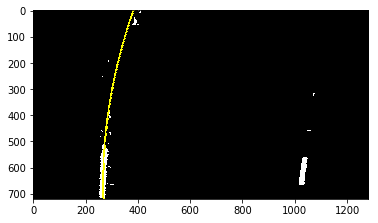

fit poly,  right
sliding windows,  right


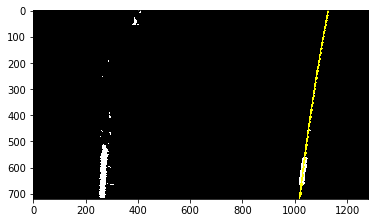

In [99]:
left_fit, ploty, left_fitx,lane_pix_img, lane_fit_img = fit_poly(bin_img, 'left', show=False)
plt.imshow(lane_fit_img)
plt.show()

right_fit, ploty, right_fitx, lane_pix_img, lane_fit_img = fit_poly(bin_img, 'right', show=False)
plt.imshow(lane_fit_img)
plt.show()

In [32]:
def proximity_search(img, side):
    print('proximity search, ', side)
    # create 3 channel image
    out_img = np.dstack((img, img, img))*255
    
    nonzero_y = np.array(img.nonzero()[0])
    nonzero_x = np.array(img.nonzero()[1])
    
    if side=='left':
        lane_inds = ((nonzero_x > 
                    (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] - margin)) 
                    & (nonzero_x < 
                    (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] + margin)))
    if side=='right':
        lane_inds = ((nonzero_x > 
                    (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] - margin)) 
                    & (nonzero_x < 
                    (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] + margin)))
    
    x = nonzero_x[lane_inds]
    y = nonzero_y[lane_inds] 
    
    ## Visualization ##
    # Colors in the left and right lane regions
    if side=='left':
        out_img[y, x] = [255, 0, 0]
    if side=='right':
        out_img[y, x] = [0, 0, 255]
    
#     if show==True:
#         src_img = np.copy(img)
#         lane_img = np.zeros_like(src_img)
#         lane_img[left_y, left_x] = [255, 0, 0]
#         lane_img[right_y, right_y] = [0, 0, 255]
#         cv2.addWeighted(src_img, 1, lane_img, 1, 0)
    
    return (x, y, out_img)

In [33]:
# leftx, lefty, rightx, righty, out_imt = proximity_search(bin_img)

In [34]:
# conversion from pixel space to meters
ym_per_pix = 21/720
xm_per_pix = 3.7/900

#### Criteria: Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

$R_{curve} = \frac{(1 + (2 Ay + B)²)^{3/2}}{\lvert2A\rvert}$

In [35]:
def curve_radius(x_vals, y_vals):
    
    real_fit = np.polyfit(y_vals*ym_per_pix, x_vals*xm_per_pix, 2)
    
    num = (1 + (2*real_fit[0]*np.max(y_vals)*ym_per_pix + real_fit[1])**2)**(3/2)
    denum = np.abs(2*real_fit[0])
    radius = num/denum
    
    return radius

def get_offset(left_fitx, right_fitx):
    # check if values for both lines exist
    if (left_fitx==[] or right_fitx==[]):
        return np.nan #-999
    else:
        lane_mid = np.mean([left_fitx[-1], right_fitx[-1]])
        center = img_size[0]//2
        # negative value means car is left from center
        offset = (center - lane_mid)*xm_per_pix
        
        return offset

In [36]:
left_radius = curve_radius(left_fitx, ploty)
right_radius = curve_radius(right_fitx, ploty)
radius = np.mean([left_radius, right_radius])
print(radius)

offset = get_offset(left_fitx, right_fitx)
print(offset)

1115.79920068
-0.00822222222222


#### Criteria: Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

In [37]:
# create black image to visualize detected pixels, windows and lane lines
# def show_detected_lane_pixels(left_x, left_y, right_x, right_y, img_size):
def show_detected_lane_pixels(left_x, left_y, right_x, right_y):
    blk_img = np.zeros_like(bin_img)
#     blk_img = np.zeros(img_size)
    lane_img_bird = np.dstack((blk_img, blk_img, blk_img))
    lane_img_bird[left_y, left_x] = [255, 0, 0]
    lane_img_bird[right_y, right_x] = [0, 0, 255]
#     plt.imshow(lane_img_bird)
    return lane_img_bird

def plot_lanes_on_image(left_x, left_y, right_x, right_y, undist_img):
    lane_img_bird = show_detected_lane_pixels(left_x, left_y, right_x, right_y)
    unwarped_lane_img = cv2.warpPerspective(lane_img_bird, warp_inv_mtx, img_size, flags = cv2.INTER_LINEAR)
    plt.figure(); plt.imshow(unwarped_lane_img)
    weighted_img = cv2.addWeighted(undist_img, 1, unwarped_lane_img, 1, 0)
    plt.figure(); plt.imshow(weighted_img)
    return 

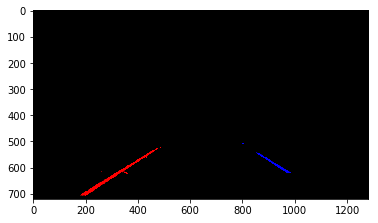

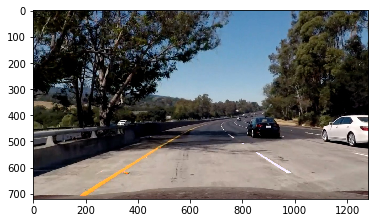

In [38]:
weighted_img = plot_lanes_on_image(left_x, left_y, right_x, right_y, undist_img)
# plt.imshow(weighted_img)

undist_img_cp = np.copy(undist_img)

In [39]:
def plot_lane_area(left_fitx, right_fitx, ploty, undist_img):
    
    if not left_fitx.any():
        return undist_img
    else:
        warped_lane_img = np.zeros_like(undist_img)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        line_pts = np.hstack((left_line, right_line))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(warped_lane_img, np.int_([line_pts]), (0,255, 0))

        unwarped_lane_img = cv2.warpPerspective(warped_lane_img, warp_inv_mtx, img_size, flags = cv2.INTER_LINEAR)

        weighted_img = cv2.addWeighted(undist_img, 1, unwarped_lane_img, 0.3, 0)
    
    return weighted_img

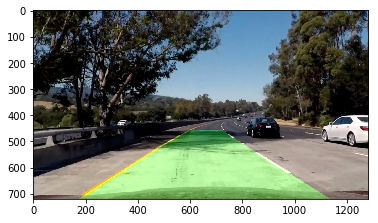

In [40]:
overlay_img = plot_lane_area(left_fitx, right_fitx, ploty, undist_img_cp)
plt.imshow(overlay_img)

In [41]:
def plot_txt(img, radius, offset):
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_size = 1.5
    thickness = 3
    pos_rad = (100, 100)
    pos_off = (100, 180)
    cv2.putText(img, 'curvature radius: {:.2f}m'.format(radius), pos_rad, font_face, 
                font_size, (255,255,255), thickness)
    if offset<0:
        cv2.putText(img, 'Vehicle pos: {:.2f}m left from center'.format(offset), pos_off, font_face, 
                    font_size, (255,255,255), thickness)
    else:
        cv2.putText(img, 'Vehicle pos: {:.2f}m right from center'.format(offset), pos_off, font_face, 
                    font_size, (255,255,255), thickness)

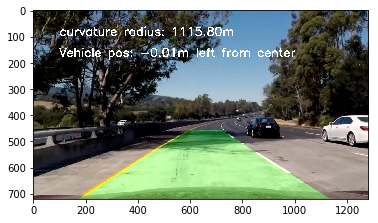

In [42]:
plot_txt(overlay_img, radius, offset)
plt.imshow(overlay_img)

In [43]:
def sanity_check(left_fit, right_fit, left_fitx, right_fitx):
    print('sanity check')
    left_line.radius = curve_radius(left_fitx, ploty)
    right_line.radius = curve_radius(right_fitx, ploty)
    
    # check if left and right lines don't have similar curvature
    if (np.abs(left_line.radius - right_line.radius) < 500):
#         print('1st check passed')
        # check if distance is plausible
        bottom_dist = (right_fitx[img_size[1]-1] - left_fitx[img_size[1]-1])*xm_per_pix
        middle_dist = (right_fitx[img_size[1]//2] - left_fitx[img_size[1]//2])*xm_per_pix
        top_dist = (right_fitx[0] - left_fitx[0])*xm_per_pix
        avg_lane_dist = np.mean([bottom_dist, middle_dist, top_dist])
        if (abs(avg_lane_dist - 3.7) < 1):
#             print('2nd check passed')
            # check if current line is similar to previous lines
#             if left_line.detection_hist.any

            left_line.count_fails == 0
            left_line.detected = True
            left_line.recent_xfitted.append(left_fitx)
            left_line.bestx = np.mean(left_line.recent_xfitted, axis=0)
            left_line.best_fit = np.polyfit(ploty, left_line.bestx, 2)
            left_line.current_fit = left_fit
#             left_line.radius = left_radius
            left_line.recent_curverad.append(left_line.radius)
            left_line.best_rad = np.mean(left_line.recent_curverad)
            left_line.allx = left_fitx
            left_line.ally = ploty            
            
            right_line.count_fails == 0
            right_line.detected = True
            right_line.recent_xfitted.append(right_fitx)
            right_line.bestx = np.mean(right_line.recent_xfitted, axis=0)
            right_line.best_fit = np.polyfit(ploty, right_line.bestx, 2)
            right_line.current_fit = right_fit
#             right_line.radius = right_radius
            right_line.recent_curverad.append(right_line.radius)
            right_line.best_rad = np.mean(right_line.recent_curverad)
            right_line.allx = right_fitx
            right_line.ally = ploty

            return (left_line.bestx, right_line.bestx)
            
        else:
            print('2nd check failed')
            left_line.count_fails += 1
            # check if 10 lines failed in a row
            if left_line.count_fails == hist_len:
                print('Too many undetected lines. Restart with sliding windows')
                # reset objects
                left_line.reset()
                right_line.reset()
                left_line.best_rad = np.nan
                right_line.best_rad = np.nan
                return (np.zeros_like(left_fitx), np.zeros_like(right_fitx))
            return (np.zeros_like(left_fitx), np.zeros_like(right_fitx))
#             return (left_line.bestx, right_line.bestx)
    else:
        print('1st check failed')
        print('left_rad: ', left_line.radius)
        print('right_rad:', right_line.radius)
        # line instances still empty
        if len(left_line.recent_xfitted)==0:
            print('no lines detected and no line history available')
            left_line.best_rad = np.nan
            right_line.best_rad = np.nan
            return (np.zeros_like(left_fitx), np.zeros_like(right_fitx))
        else:
            left_line.count_fails += 1
            if left_line.count_fails == hist_len:
                print('Too many undetected lines. Restart with sliding windows')
                # reset objects
                left_line.reset()
                right_line.reset()
                left_line.best_rad = np.nan
                right_line.best_rad = np.nan
                return (np.zeros_like(left_fitx), np.zeros_like(right_fitx))

            return (left_line.bestx, right_line.bestx) 
            return (np.zeros_like(left_fitx), np.zeros_like(right_fitx))

In [44]:
hist_len = 3
left_line = Line(hist_len)
right_line = Line(hist_len)

In [58]:
def create_comb_img(main_img, side_img1_in, side_img2_in, side_img3_in, side_img4_in, side_img5_in):

    main_shape = main_img.shape

    # prepare images
    final_shape = (int(main_shape[0]*1.5), int(main_shape[1]*1.5),3)
    half_shape = (main_shape[0]//2, main_shape[1]//2)
    final_img = np.zeros(final_shape, dtype=src_img.dtype)

    side_img1 = cv2.resize(side_img1_in, half_shape[::-1])
    if len(side_img1.shape)==2:
        side_img1 = side_img1*255
        side_img1 = np.dstack((side_img1, side_img1, side_img1))

    side_img2 = cv2.resize(side_img2_in, half_shape[::-1])
    if len(side_img2.shape)==2:
        side_img2 = side_img2*255
        side_img2 = np.dstack((side_img2, side_img2, side_img2))

    side_img3 = cv2.resize(side_img3_in, half_shape[::-1])
    if len(side_img3.shape)==2:
        side_img3 = side_img3*255
        side_img3 = np.dstack((side_img3, side_img3, side_img3))

    side_img4 = cv2.resize(side_img4_in, half_shape[::-1])
    if len(side_img4.shape)==2:
        side_img4 = side_img4*255
        side_img4 = np.dstack((side_img4, side_img4, side_img4))
        
    side_img5 = cv2.resize(side_img5_in, half_shape[::-1])
    if len(side_img5.shape)==2:
        side_img5 = side_img5*255
        side_img5 = np.dstack((side_img5, side_img5, side_img5))


    # fill final image
    # main image
    final_img[-main_shape[0]:,-main_shape[1]:] = main_img
    # side image 1 (top left)
    final_img[:-main_shape[0],:-main_shape[1]] = side_img1
    # side image 2 (top middle)
    final_img[:-main_shape[0],-main_shape[1]:main_shape[1]] = side_img2
    # side image 3 (top right)
    final_img[:-main_shape[0],main_shape[1]:] = side_img3
    # side image 4 (left mid)
    final_img[-main_shape[0]:main_shape[0],:-main_shape[1]] = side_img4
    # side image 5 (left bottom)
    final_img[main_shape[0]:,:-main_shape[1]] = side_img5


    # test = cv2.resize(src_img, (half_shape))
#     show_img(src_img)
#     show_img(final_img)

    return final_img

In [59]:
def pipeline(src_img):
    
    undist_img = undistort(src_img)
    
    warped_img = warp(undist_img)
    
#     bin_img = color_s_thresh(warped_img, thresh = (120, 255))
    bin_img = create_bin_img(warped_img)
    
    left_fit, ploty, left_fitx, lane_pix_img_left, lane_fit_img_left = fit_poly(bin_img, 'left')
    right_fit, ploty, right_fitx, lane_pix_img_right, lane_fit_img_right = fit_poly(bin_img, 'right')
    
    left_fitx, right_fitx = sanity_check(left_fit, right_fit, left_fitx, right_fitx)
    offset = get_offset(left_fitx, right_fitx)
    
    lane_img = plot_lane_area(left_fitx, right_fitx, ploty, undist_img)
    plot_txt(lane_img, np.mean([left_line.best_rad, right_line.best_rad]), offset)
    
    comb_img = create_comb_img(lane_img, warped_img, lane_pix_img_left, lane_pix_img_right, lane_fit_img_left, lane_fit_img_right)
    
    return comb_img
#     return lane_area_img
#     return np.dstack((bin_img, bin_img, bin_img))*255 

fit poly,  left
sliding windows,  left
fit poly,  right
sliding windows,  right
sanity check
1st check failed
left_rad:  1804.0045524
right_rad: 788.596052491
no lines detected and no line history available


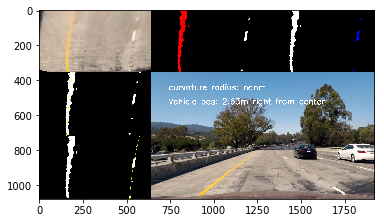

In [60]:

# read image and get size
# src_img = mpimg.imread('test_images/straight_lines1.jpg')
src_img = mpimg.imread('test_images/test1.jpg')
img_size = (src_img.shape[1], src_img.shape[0])

dst_img = pipeline(src_img)
show_img(dst_img)

In [61]:
white_output = 'output_videos/project_video.mp4'
# clip1 = VideoFileClip("project_video.mp4").subclip(38,40)
clip1 = VideoFileClip("project_video.mp4").subclip(38,40)
# clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   4%|▍         | 2/50 [00:00<00:02, 19.10it/s, now=None]

fit poly,  left
sliding windows,  left
fit poly,  right
sliding windows,  right
sanity check
Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4

fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check


t:  10%|█         | 5/50 [00:00<00:03, 13.70it/s, now=None]

fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check


t:  14%|█▍        | 7/50 [00:00<00:03, 14.01it/s, now=None]

fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  

t:  22%|██▏       | 11/50 [00:00<00:02, 14.44it/s, now=None]

left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  left
proximity search,  left


t:  26%|██▌       | 13/50 [00:00<00:02, 14.37it/s, now=None]

fit poly,  right
proximity search,  right
sanity check
1st check failed
left_rad:  722.371399211
right_rad: 1245.46437329
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right


t:  34%|███▍      | 17/50 [00:01<00:02, 14.53it/s, now=None]

sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
1st check failed
left_rad:  1233.37931776
right_rad: 516.198085879
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
1st check failed
left_rad:  1027.0041828
right_rad: 502.441089047
Too many undetected lines. Restart with sliding windows
fit poly,  left
sliding windows,  left
fit poly,  right
sliding windows,  right


t:  42%|████▏     | 21/50 [00:01<00:01, 15.11it/s, now=None]

sanity check
1st check failed
left_rad:  1125.95159521
right_rad: 519.968031299
no lines detected and no line history available
fit poly,  left
sliding windows,  left
fit poly,  right
sliding windows,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
1st check failed
left_rad:  950.388882534
right_rad: 430.943615531
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check


t:  46%|████▌     | 23/50 [00:01<00:01, 15.13it/s, now=None]

fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
1st check failed
left_rad:  6573.29738179
right_rad: 539.706908098
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
1st check failed
left_rad:  4886.12162938
right_rad: 590.643278847
Too many undetected lines. Restart with sliding windows
fit poly,  left
sliding windows,  left


t:  54%|█████▍    | 27/50 [00:01<00:01, 15.57it/s, now=None]

fit poly,  right
sliding windows,  right
sanity check
1st check failed
left_rad:  2683.46656046
right_rad: 940.664095313
no lines detected and no line history available
fit poly,  left
sliding windows,  left
fit poly,  right
sliding windows,  right
sanity check
1st check failed
left_rad:  2984.87293231
right_rad: 978.003636172
no lines detected and no line history available
fit poly,  left
sliding windows,  left
fit poly,  right
sliding windows,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right


t:  62%|██████▏   | 31/50 [00:02<00:01, 15.94it/s, now=None]

sanity check
1st check failed
left_rad:  1164.06507015
right_rad: 2204.93035567
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
1st check failed
left_rad:  600.031369154
right_rad: 2270.36827886
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
1st check failed
left_rad:  816.011298567
right_rad: 4263.53436034
Too many undetected lines. Restart with sliding windows
fit poly,  left
sliding windows,  left
fit poly,  right
sliding windows,  right
sanity check
1st check failed
left_rad:  1843.79086026
right_rad: 3214.57751898
no lines detected and no line history available


t:  66%|██████▌   | 33/50 [00:02<00:01, 15.64it/s, now=None]

fit poly,  left
sliding windows,  left
fit poly,  right
sliding windows,  right
sanity check
1st check failed
left_rad:  2431.92593948
right_rad: 947.608589793
no lines detected and no line history available
fit poly,  left
sliding windows,  left
fit poly,  right
sliding windows,  right
sanity check
1st check failed
left_rad:  2991.79877849
right_rad: 993.241042741
no lines detected and no line history available
fit poly,  left
sliding windows,  left
fit poly,  right
sliding windows,  right
sanity check
fit poly,  left
proximity search,  left


t:  74%|███████▍  | 37/50 [00:02<00:00, 15.33it/s, now=None]

fit poly,  right
proximity search,  right
sanity check
1st check failed
left_rad:  1440.42983241
right_rad: 2730.64177596
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
1st check failed
left_rad:  1109.51585827
right_rad: 437.203375337
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right


t:  78%|███████▊  | 39/50 [00:02<00:00, 15.34it/s, now=None]

sanity check
1st check failed
left_rad:  955.899961589
right_rad: 452.551731312
Too many undetected lines. Restart with sliding windows
fit poly,  left
sliding windows,  left
fit poly,  right
sliding windows,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
1st check failed
left_rad:  944.840815923
right_rad: 427.557313584
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
1st check failed
left_rad:  1292.7351428
right_rad: 459.452926531


t:  86%|████████▌ | 43/50 [00:02<00:00, 15.17it/s, now=None]

fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check


t:  94%|█████████▍| 47/50 [00:03<00:00, 14.31it/s, now=None]

fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check


t:  98%|█████████▊| 49/50 [00:03<00:00, 13.64it/s, now=None]

fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check


fit poly,  left
proximity search,  left
fit poly,  right
proximity search,  right
sanity check
Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
CPU times: user 9.53 s, sys: 499 ms, total: 10 s
Wall time: 4.69 s


In [62]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# backup

In [ ]:
# ### todo: class and functions descriptions
# class Calibration:
    
#     def __init__(self, cam_mtx, dist_coeff, src_pts, dst_pts):
#         self.cam_mtx = cam_mtx
#         self.dist_coeff = dist_coeff
#         self.src_pts = src_pts
#         selfdd.dst_pts = dst_pts
#         self.warp_mtx = cv2.get_PerspectiveTransform(scr_pts, dst_pts)
        
#     def undistort(self, dist_img):
#         undist_img = cv2.undistort(dist_img, self.cam_mtx, 
#                                    self.dist_coeff, None, 
#                                    self.cam_mtx)
#         return undist_img
    
#     def warp(self, img):
#         img_size = (img.shape[1], img.shape[0])
#         warped_img = cv2.warpPerspective(img, self.warp_mtx, 
#                                          img_size, 
#                                          flags = cv2.INTER_LINEAR)
#         return warped_img

In [ ]:
# # unwarped_img = np.copy(undist_img)
# raw_img = mpimg.imread('test_images/test6.jpg')
# undist_img = calib.undistort(raw_img)
# # raw_img = mpimg.imread('test_images/test1.jpg')
# # undist_img = calib.undistort(raw_img)

# warp_mtx = cv2.getPerspectiveTransform(src_pts, dst_pts)
# warped_img = cv2.warpPerspective(undist_img, warp_mtx, 
#                                  img_size, flags=cv2.INTER_LINEAR)

# plt.figure()
# plt.imshow(undist_img)
# line_img1 = draw_lines_from_points(undist_img, src_pts)
# plt.figure()
# plt.imshow(undist_img)

# plt.figure()
# plt.imshow(warped_img)
# line_img2 = draw_lines_from_points(warped_img, dst_pts)
# plt.figure()
# plt.imshow(warped_img)
